# Detecting Spam Emails Using Tensorflow

### <font color=green>Import Required Libraries</font>

In [1]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


### Load the Dataset

In [2]:
data = pd.read_csv('Emails.csv')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
data.shape

(5728, 2)

For a better understanding about Dataframe, we’ll plot these counts:

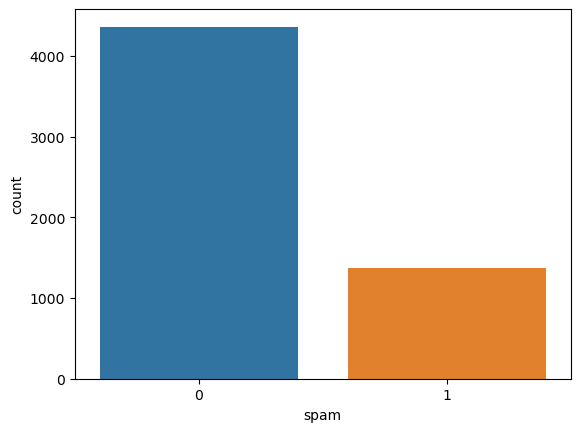

In [4]:
sns.countplot(x='spam', data=data)
plt.show()

Text(0.5, 0, 'Message types')

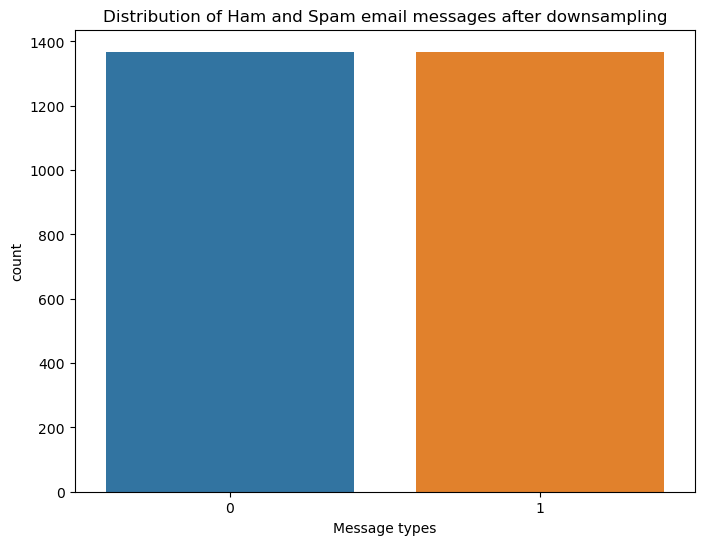

In [5]:
# Downsampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
random_state=42)

# Plotting the counts of down sampled dataset
balanced_data = ham_msg.append(spam_msg)\
    .reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

### Text  Preprocessing

In [6]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [7]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,text,spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


The function provided below serves as a helpful tool to eliminate stop words from a given text.

In [8]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
    word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


A word cloud is a visual representation of textual data where the size of each word corresponds to its frequency or importance.

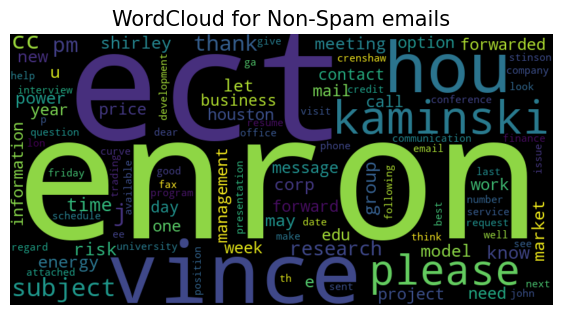

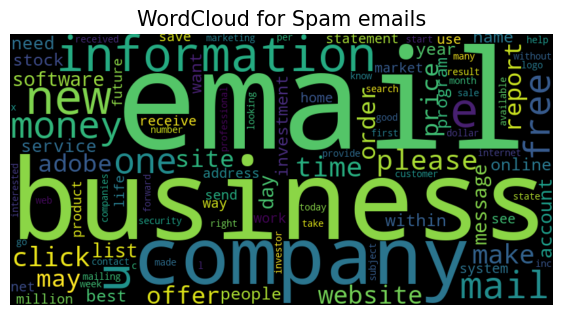

In [9]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(background_color='black',
                max_words=100,
                width=800,
                height=400,
                collocations=False).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

Word to Vector Conversion

In [10]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['spam'],
                                                    test_size = 0.2,
                                                    random_state = 42)

The tokenizer has been applied to our training data to convert both the training and validation data into vectors.

In [11]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                            maxlen=max_len,
                            padding='post',
                            truncating='post')

### Model Development - Sequential model

In [12]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           805024    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 808,737
Trainable params: 808,737
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
            metrics = ['accuracy'],
            optimizer = 'adam')

Callback

In [14]:
es = EarlyStopping(patience=3,
                monitor = 'val_accuracy',
                restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                    monitor = 'val_loss',
                    factor = 0.5,
                    verbose = 0)

### Training the model

In [15]:
# Train the model
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks = [lr, es]
                )

Epoch 1/20
69/69 [==============================] - 11s 87ms/step - loss: 0.6655 - accuracy: 0.6001 - val_loss: 0.5150 - val_accuracy: 0.7719 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 5s 80ms/step - loss: 0.2566 - accuracy: 0.9356 - val_loss: 0.3795 - val_accuracy: 0.9106 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 6s 80ms/step - loss: 0.1708 - accuracy: 0.9612 - val_loss: 0.1653 - val_accuracy: 0.9599 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 5s 75ms/step - loss: 0.1291 - accuracy: 0.9685 - val_loss: 0.1068 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 5s 75ms/step - loss: 0.0924 - accuracy: 0.9790 - val_loss: 0.0993 - val_accuracy: 0.9763 - lr: 0.0010
Epoch 6/20
69/69 [==============================] - 5s 76ms/step - loss: 0.0690 - accuracy: 0.9854 - val_loss: 0.1057 - val_accuracy: 0.9763 - lr: 0.0010
Epoch 7/20
69/69 [==============================] - 5s 74ms/step - loss: 0.

evaluate the model using the validation data

In [16]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

18/18 [==============================] - 0s 19ms/step - loss: 0.0898 - accuracy: 0.9818
Test Loss : 0.08978040516376495
Test Accuracy : 0.9817517995834351


 The training accuracy is calculated to be 98.18%

### Model Evaluation Results :

With the model trained, we can now generate a graph to illustrate how the training and validation accuracies vary across different epochs.

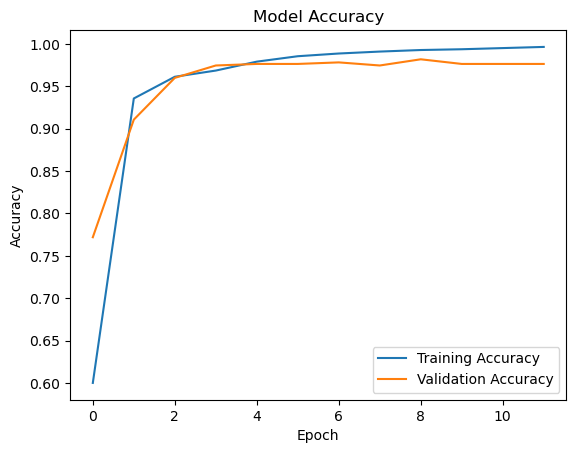

In [17]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()